In [1]:
cd(@__DIR__)
include(raw"utils\utils.jl")

mulmedian (generic function with 1 method)

Making a calendar of 100 years

In [2]:
try 
    using Dates
catch ; 
    import Pkg
    Pkg.add("Dates")
    using Dates
end
k=100
DatesRange=collect(Date(1900):Day(1):Date(1900+k))
N=length(DatesRange)

36525

# AR model on the whole series

## AR(2)

In [3]:
condition(r) = (imag(r) == 0) && (abs(r) > 1)
isstationnary(R::Vector)=all(condition.(RootAR(R)))

isstationnary (generic function with 1 method)

In [4]:
x0=[7.,-3]
Φ,σ=[0.1,0.5],6
isstationnary([0.1,0.5])

true

In [5]:
include("utils/Simulation.jl")
x=[x0 ; simulation(x0,Φ,σ,N-length(x0))]

36525-element Vector{Float64}:
   7.0
  -3.0
  -2.104828967577915
   4.717414994968363
  -5.90258153511969
   6.786966903475898
  -6.971726044152218
   7.592002020086968
  -8.325064511481346
   6.093604147497701
   ⋮
  -1.2526688055227497
   6.228210938821366
  -0.47832682604947474
  13.074309477500233
 -15.247450989268277
   5.5322099681183285
 -12.598377720954058
  -5.0590294957914175
  -6.13674829935671

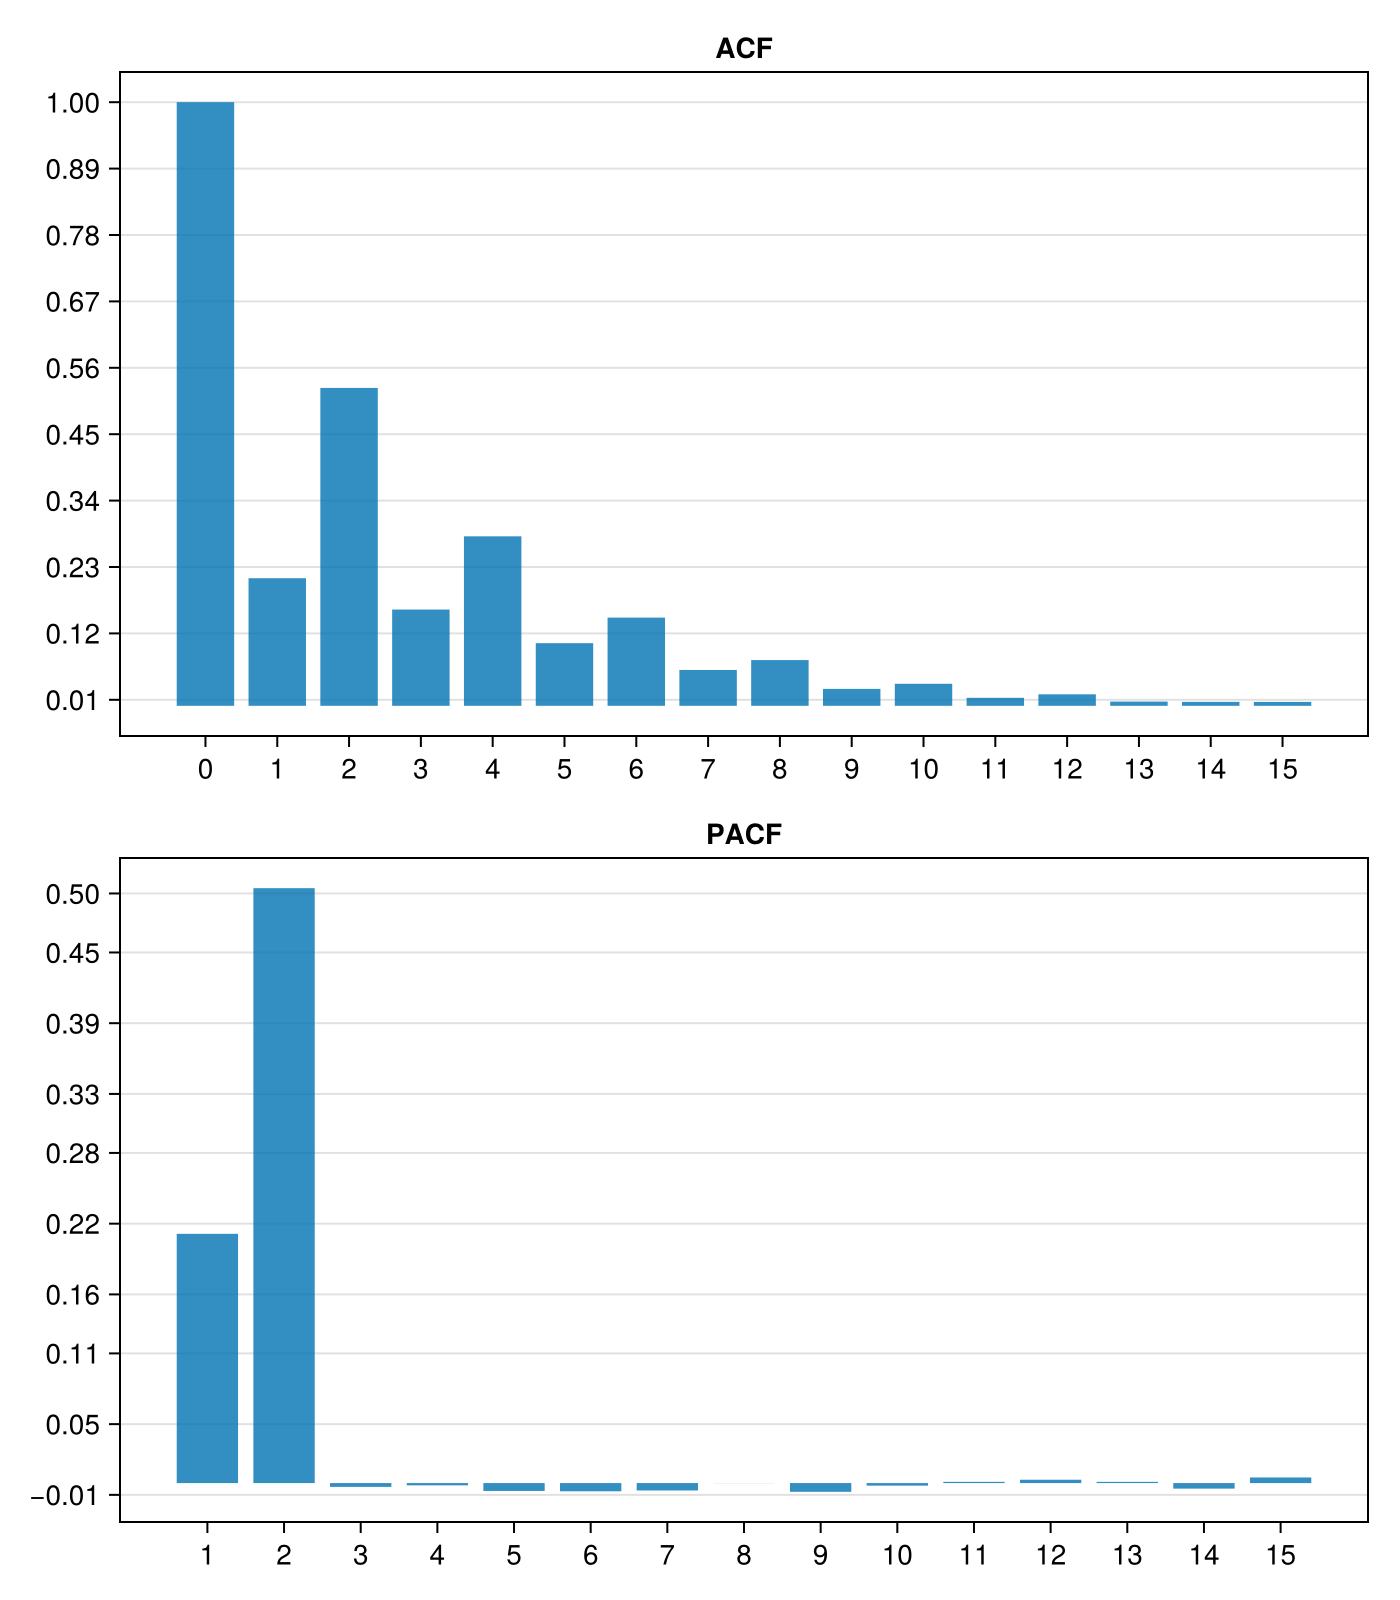

In [6]:
include("utils/ACF_PACF.jl")
ACF_PACF(x)

In [7]:
include("utils/Estimation.jl")
Parameters_est=LL_AR_Estimation(x,2)
Φ1_hat, Φ2_hat, σ_hat=Parameters_est[1][1], Parameters_est[1][2], Parameters_est[2]
table = DataFrame("Parameters"=>"Φ₁", "Error"=>abs(Φ1_hat-Φ[1]), "Relative error"=>abs(Φ1_hat-Φ[1])/abs(Φ[1]))
push!(table,("Φ₂",abs(Φ2_hat-Φ[2]),abs(Φ2_hat-Φ[2])/abs(Φ[2])))
push!(table,("σ",abs(σ_hat-σ),abs(σ_hat-σ)/abs(σ)))

Row,Parameters,Error,Relative error
,String,Float64,Float64
1,Φ₁,0.00482105,0.0482105
2,Φ₂,0.00455599,0.00911198
3,σ,0.00913487,0.00152248


# AR model on each month

Parameters for each month

To find convenient parameters, below I have made an empirical map of where the parameters make the AR(2) series stationnary (in blue) and where they don't (in red)

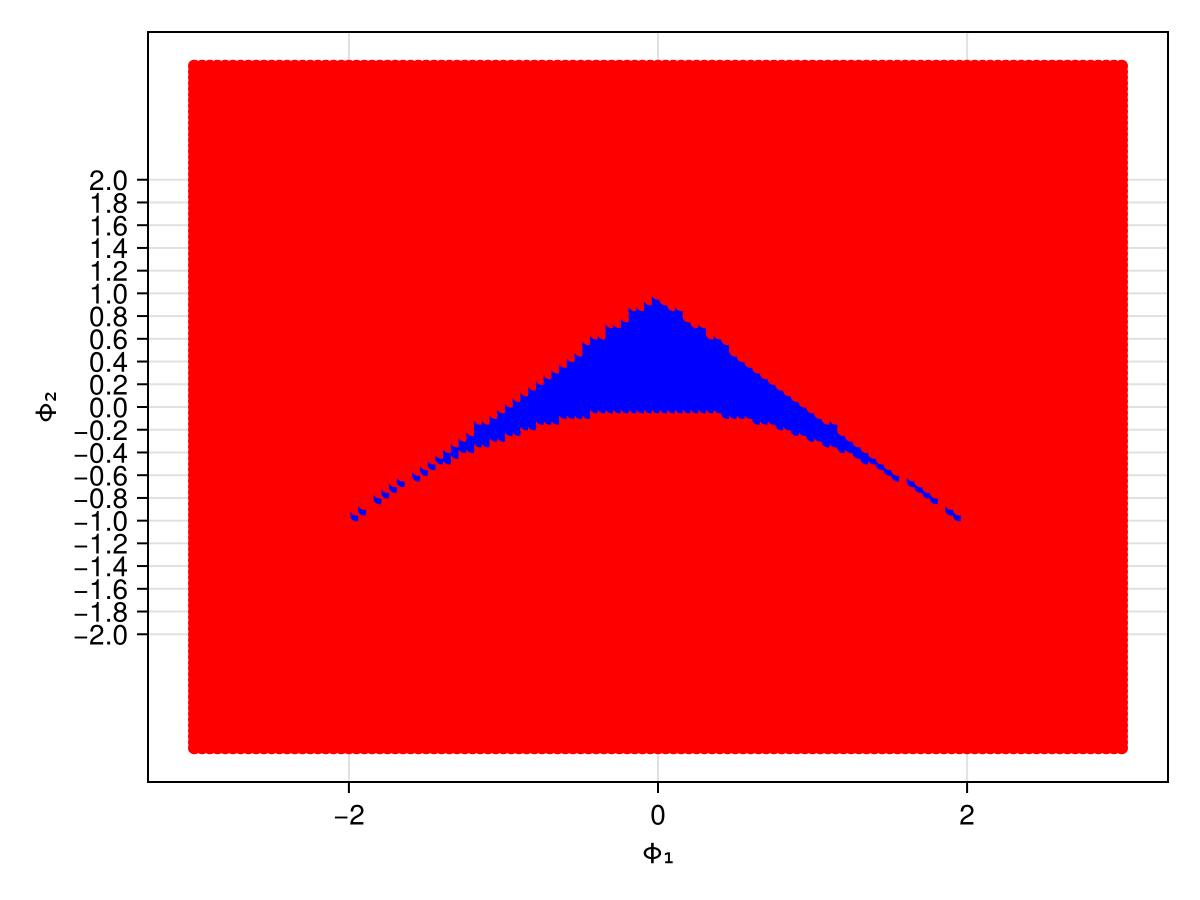

In [8]:
fig=Figure()
ax=Axis(fig[1,1])
ax.yticks=-2:0.2:2
Φ₁ls=-3:.05:3
Φ₂ls=-3:.05:3
condition(r) = (imag(r) == 0) && (abs(r) > 1)
for Φ₁ in Φ₁ls
    for Φ₂ in Φ₂ls
        color = all(condition.(RootAR([Φ₁,Φ₂]))) ? "blue" : "red" 
        scatter!(ax, Φ₁,Φ₂, color=color)
        ax.ylabel="Φ₂"
        ax.xlabel="Φ₁"
    end
end
fig

In [9]:
Φ_month=[[5,2],[-7,1],[1,8],[6,2],[-2,7],[0.5,9],[-3,2],[5,4],[3,1],[-4,3],[3,1],[5,2]] / 10
display(isstationnary.(Φ_month))
Φ1_month, Φ2_month = invert(Φ_month)
σ_month=[1.5,2,4.5,7,8,3,4.5,1,7,2.5,3,6]

12-element BitVector:
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1

12-element Vector{Float64}:
 1.5
 2.0
 4.5
 7.0
 8.0
 3.0
 4.5
 1.0
 7.0
 2.5
 3.0
 6.0

Generation of the series associated

In [10]:
n_month=200
x=SimulateMonth([7.,4.],Date(2000,11,2),Φ_month,σ_month,n_month)
Date_vec=collect(Date(2000,11,1):(Date(2000,11,1) + Month(n_month) - Day(1)))
Monthly_temp=MonthlySeparateX(x,Date_vec)

12-element Vector{Vector{AbstractVector}}:
 [[3.3410934872236027, 4.012459082390096, 4.233892567069336, 2.5838633240858027, 0.43920213347969606, -1.0524730661835044, -1.163398923256925, -1.7653736650190879, -1.098908675781045, -1.324369082312294  …  -1.329648463920723, 2.2762951377573075, 0.7990258733628641, -0.1717046701302084, 0.1265244395099227, -1.128986938332704, -3.834495946565178, -0.5809519039236117, -0.9971570035592358, 0.13583222868014577], [-7.526164819082322, -5.345978862136558, 0.22951987505084137, -1.1884849563555366, 4.901618715095208, 1.502120508614753, 2.2765692527059573, 1.1710390899391783, 1.4163200815687775, -1.1074392249204812  …  -0.10707619106700594, 1.6183208923132277, 2.734471754686713, -0.968267860281355, 0.3490987282871014, 0.29909615513247867, 2.7934039005085203, 1.334776344777228, 1.7241950669142607, 0.32872052695444853], [0.175960920508197, 1.8262666226614406, 2.1743665875803093, 0.18762569872837753, 0.34926303906530454, -1.2195509356280847, -1.99040393321

## Autocorrelations

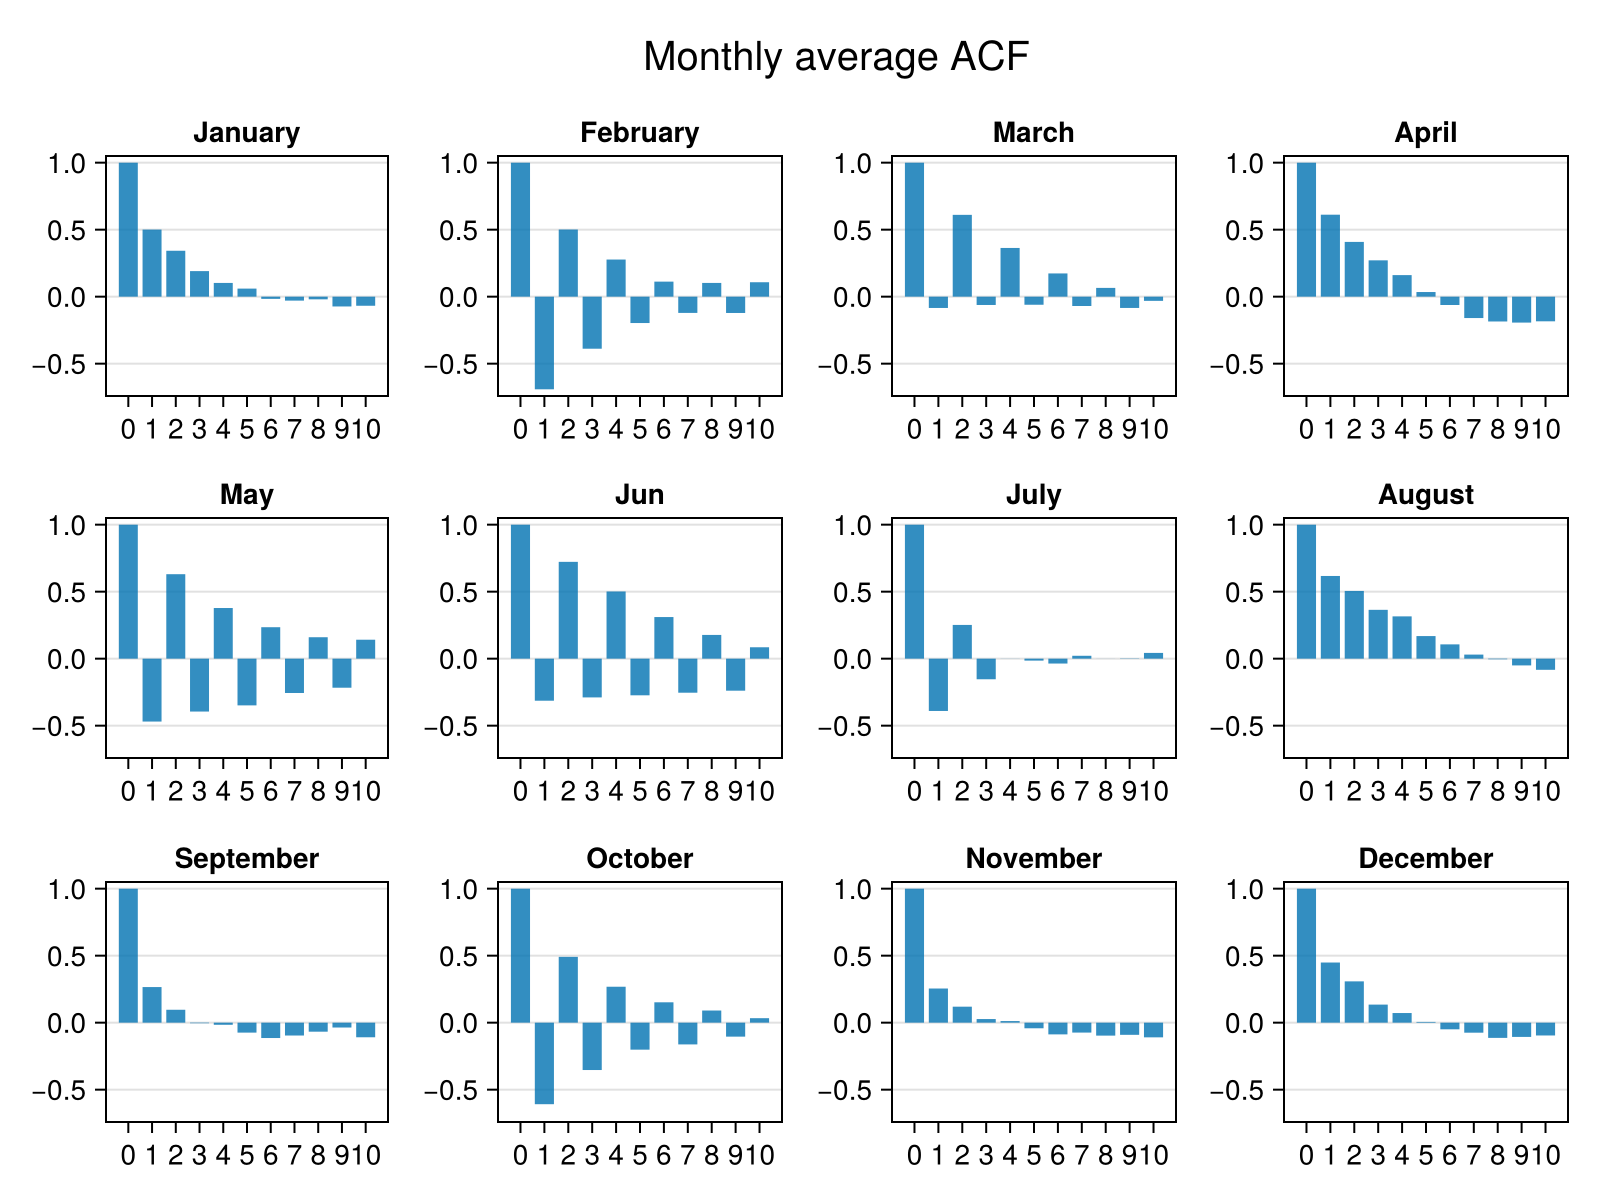

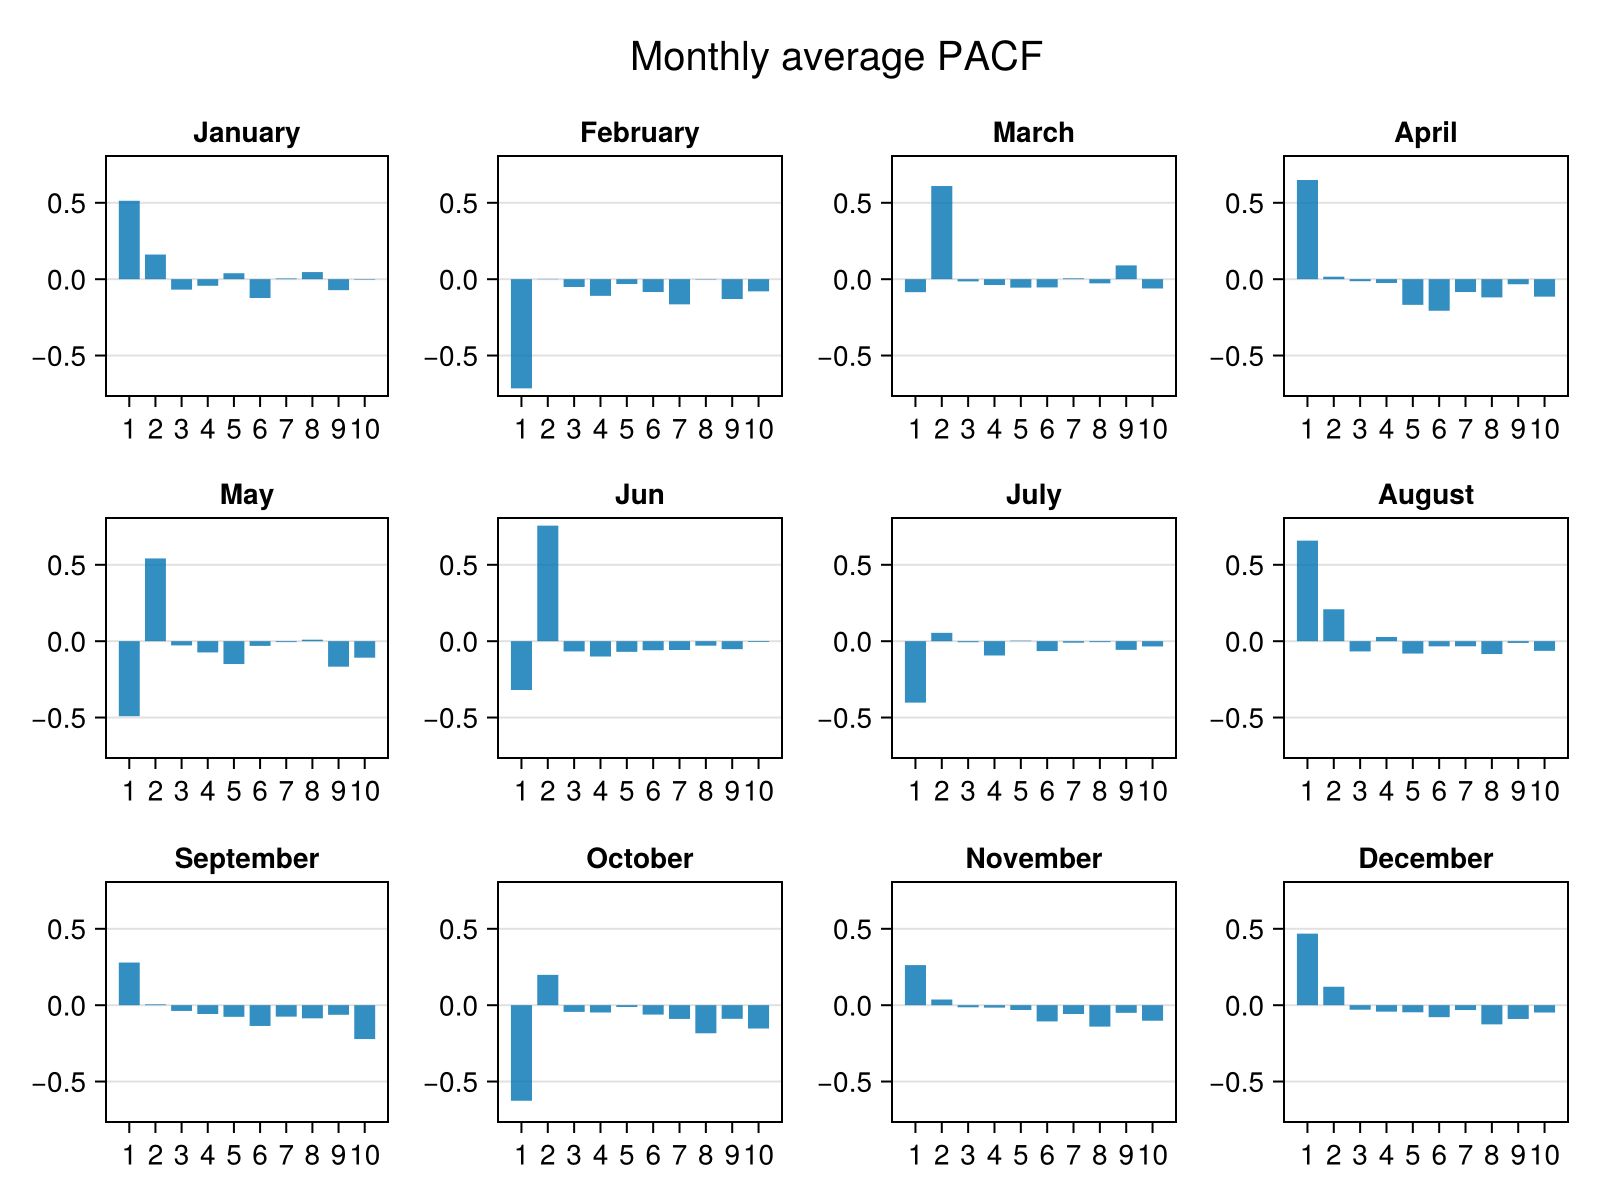

CairoMakie.Screen{IMAGE}


In [11]:
display(MonthlyACF(Monthly_temp))
display(MonthlyPACF(Monthly_temp))

## Estimating models

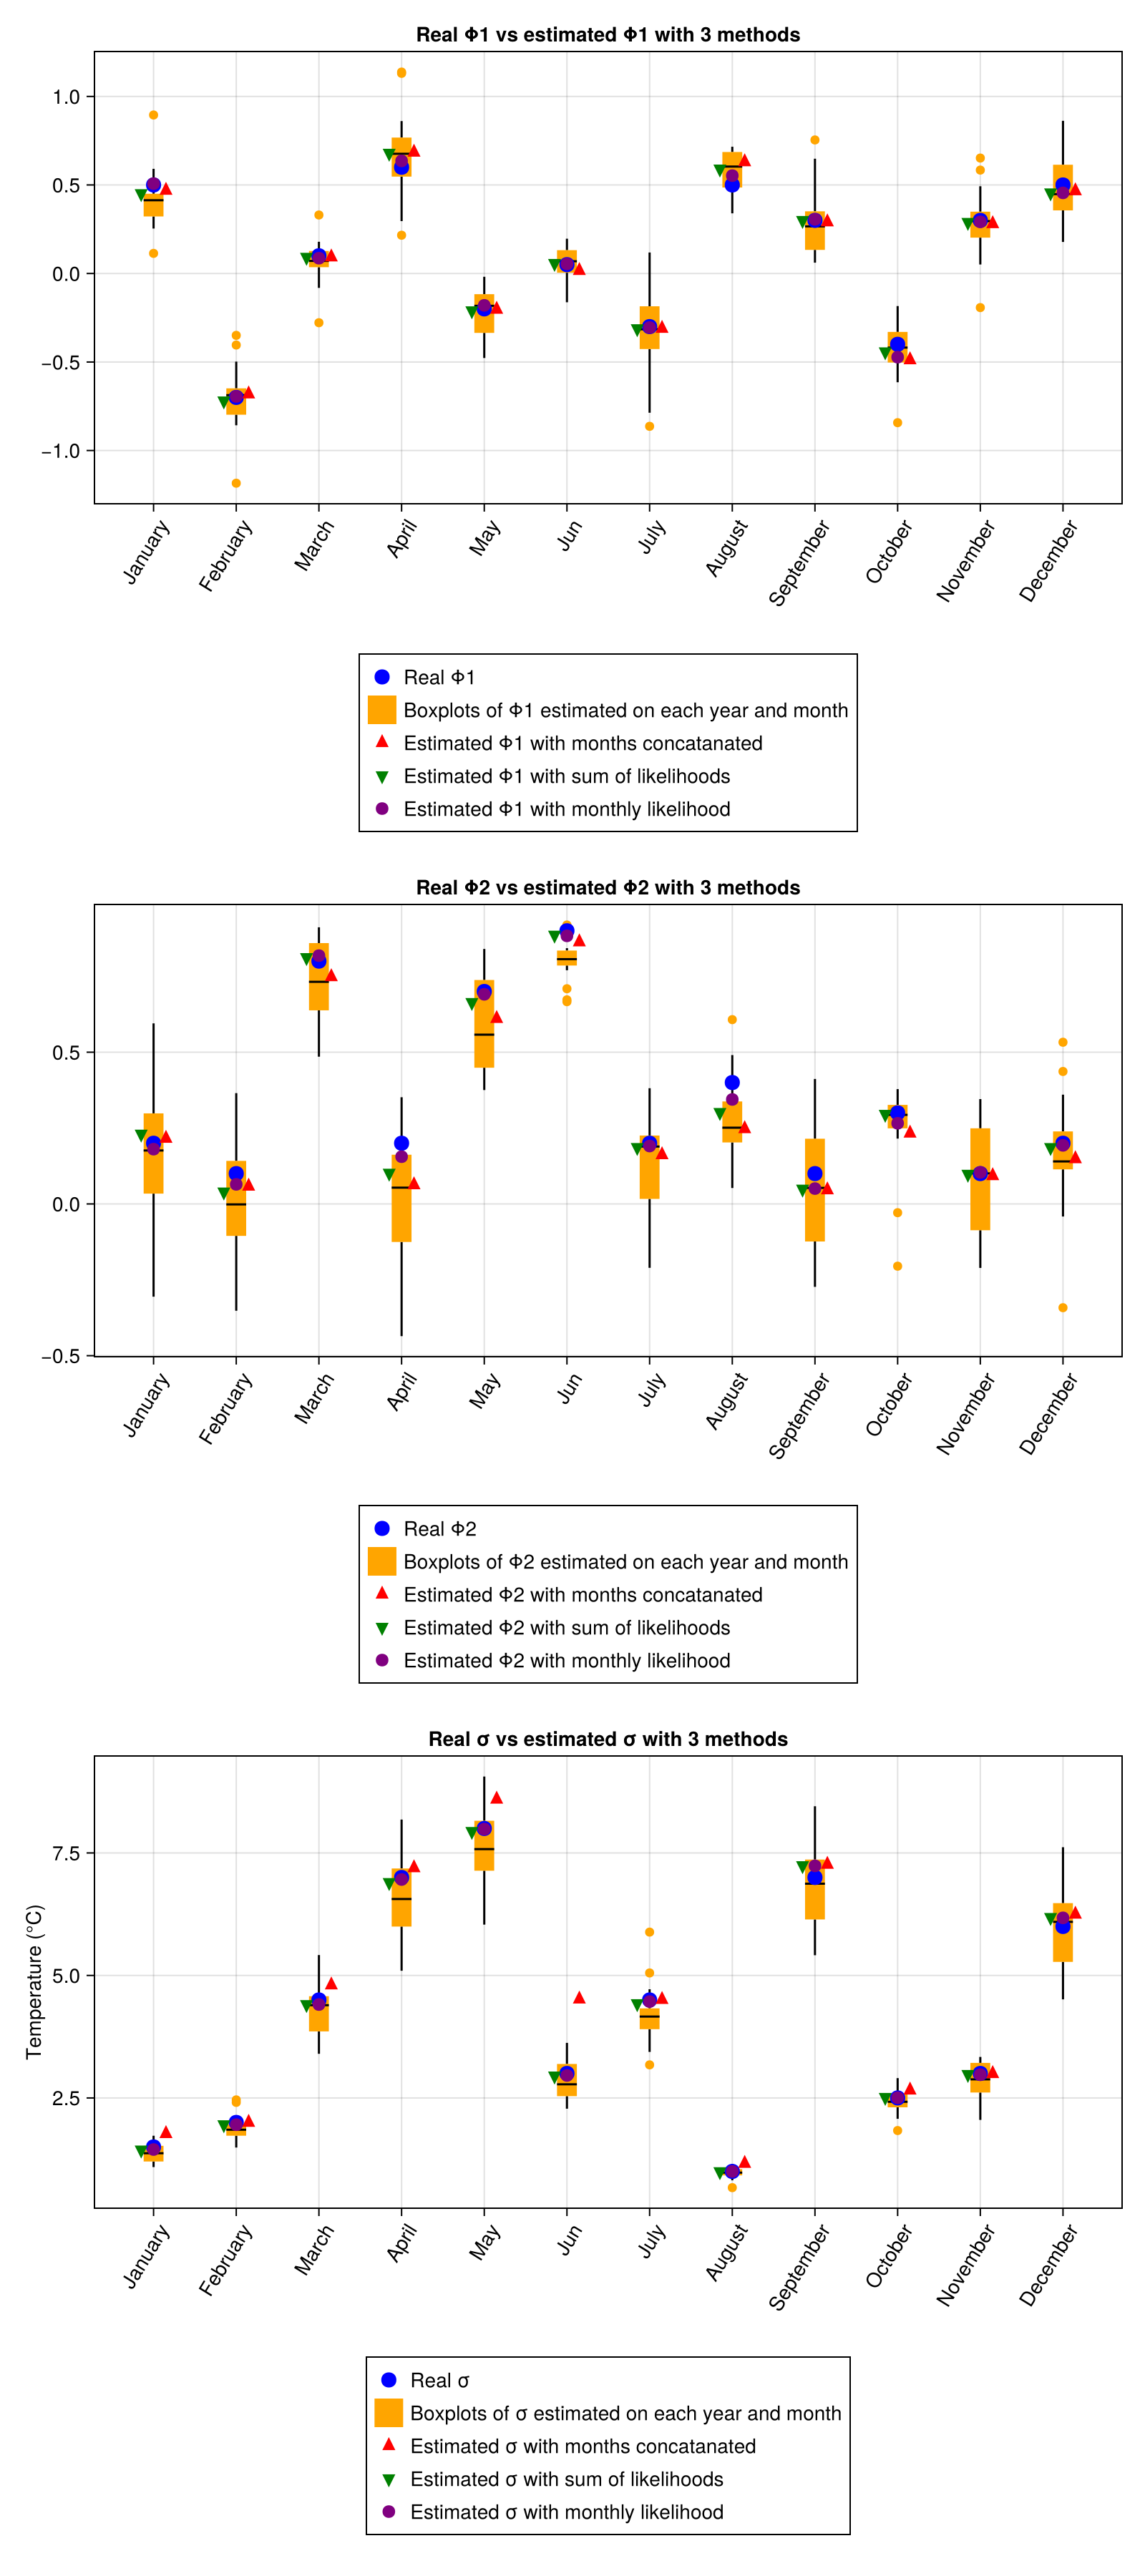

Row,Parameter,Month concatanation,Sum LL,Monthly LL,mean of monthly parameters,median of monthly parameters
,String,Float64,Float64,Float64,Float64,Float64
1,Φ1,13.9499,8.20707,7.00951,11.5758,13.439
2,Φ2,25.705,18.765,13.2964,35.1224,29.0229
3,σ,9.68922,1.81675,1.51391,4.5162,4.82584


7

In [15]:
include(raw"utils\Estimation.jl")
Parameters,autofig,ErrorTable=AllEstimation(x,2,Date_vec=Date_vec,TrueParamVec=[Φ1_month,Φ2_month,σ_month])
display(autofig)
display(ErrorTable)

In [16]:
Φ_vec, σ_vec = AutoTakeParameters((Parameters,ErrorTable))
n_years=10
sim=SimulateScenarios([4.,3.],Date(2001,1,1):(Date(2001,1,1) + Year(n_years-1)),Φ_vec, σ_vec,n=10)
sample_=GatherYearScenarios(sim,Date(2001,1,1):(Date(2001,1,1) + Year(n_years-1)))

366-element Vector{Vector{AbstractFloat}}:
 [4.0, -6.085913002582158, 0.5703845019397267, 3.6120048719687037, 7.268889183043541, 4.7867041522393645, -1.9440439430605636, -2.4394038897675103, 3.593175517503649, -0.5975894325764937  …  4.0, -11.535566756584307, -3.2614604981474753, 1.3468668819924665, -2.325991656422347, -2.9709848533650622, -11.596041445371545, -2.140838234011514, 6.443422121251864, 0.6235423266731137]
 [3.0, -6.202006548338549, 1.9740391122662153, 1.9776935565234988, 4.820995768410513, 3.5992057538978894, 0.15094389600879388, -3.5745339655810806, 5.643370428873388, 3.0  …  1.2479849633157207, 3.0, -6.037171494350497, -1.7042269225862872, 0.35429488447837143, -2.629076326086179, -1.8372125472170004, -8.492219188963773, -3.7992728845604042, 4.368243395343434]
 [2.680253480653201, -2.540431407245282, 0.3056375433896994, -0.5570026865489559, 2.0826647924348496, 3.20786665218771, 0.5055203913841405, -2.6216721778741543, 4.904563134809649, 1.2558103086326589  …  1.7115991596

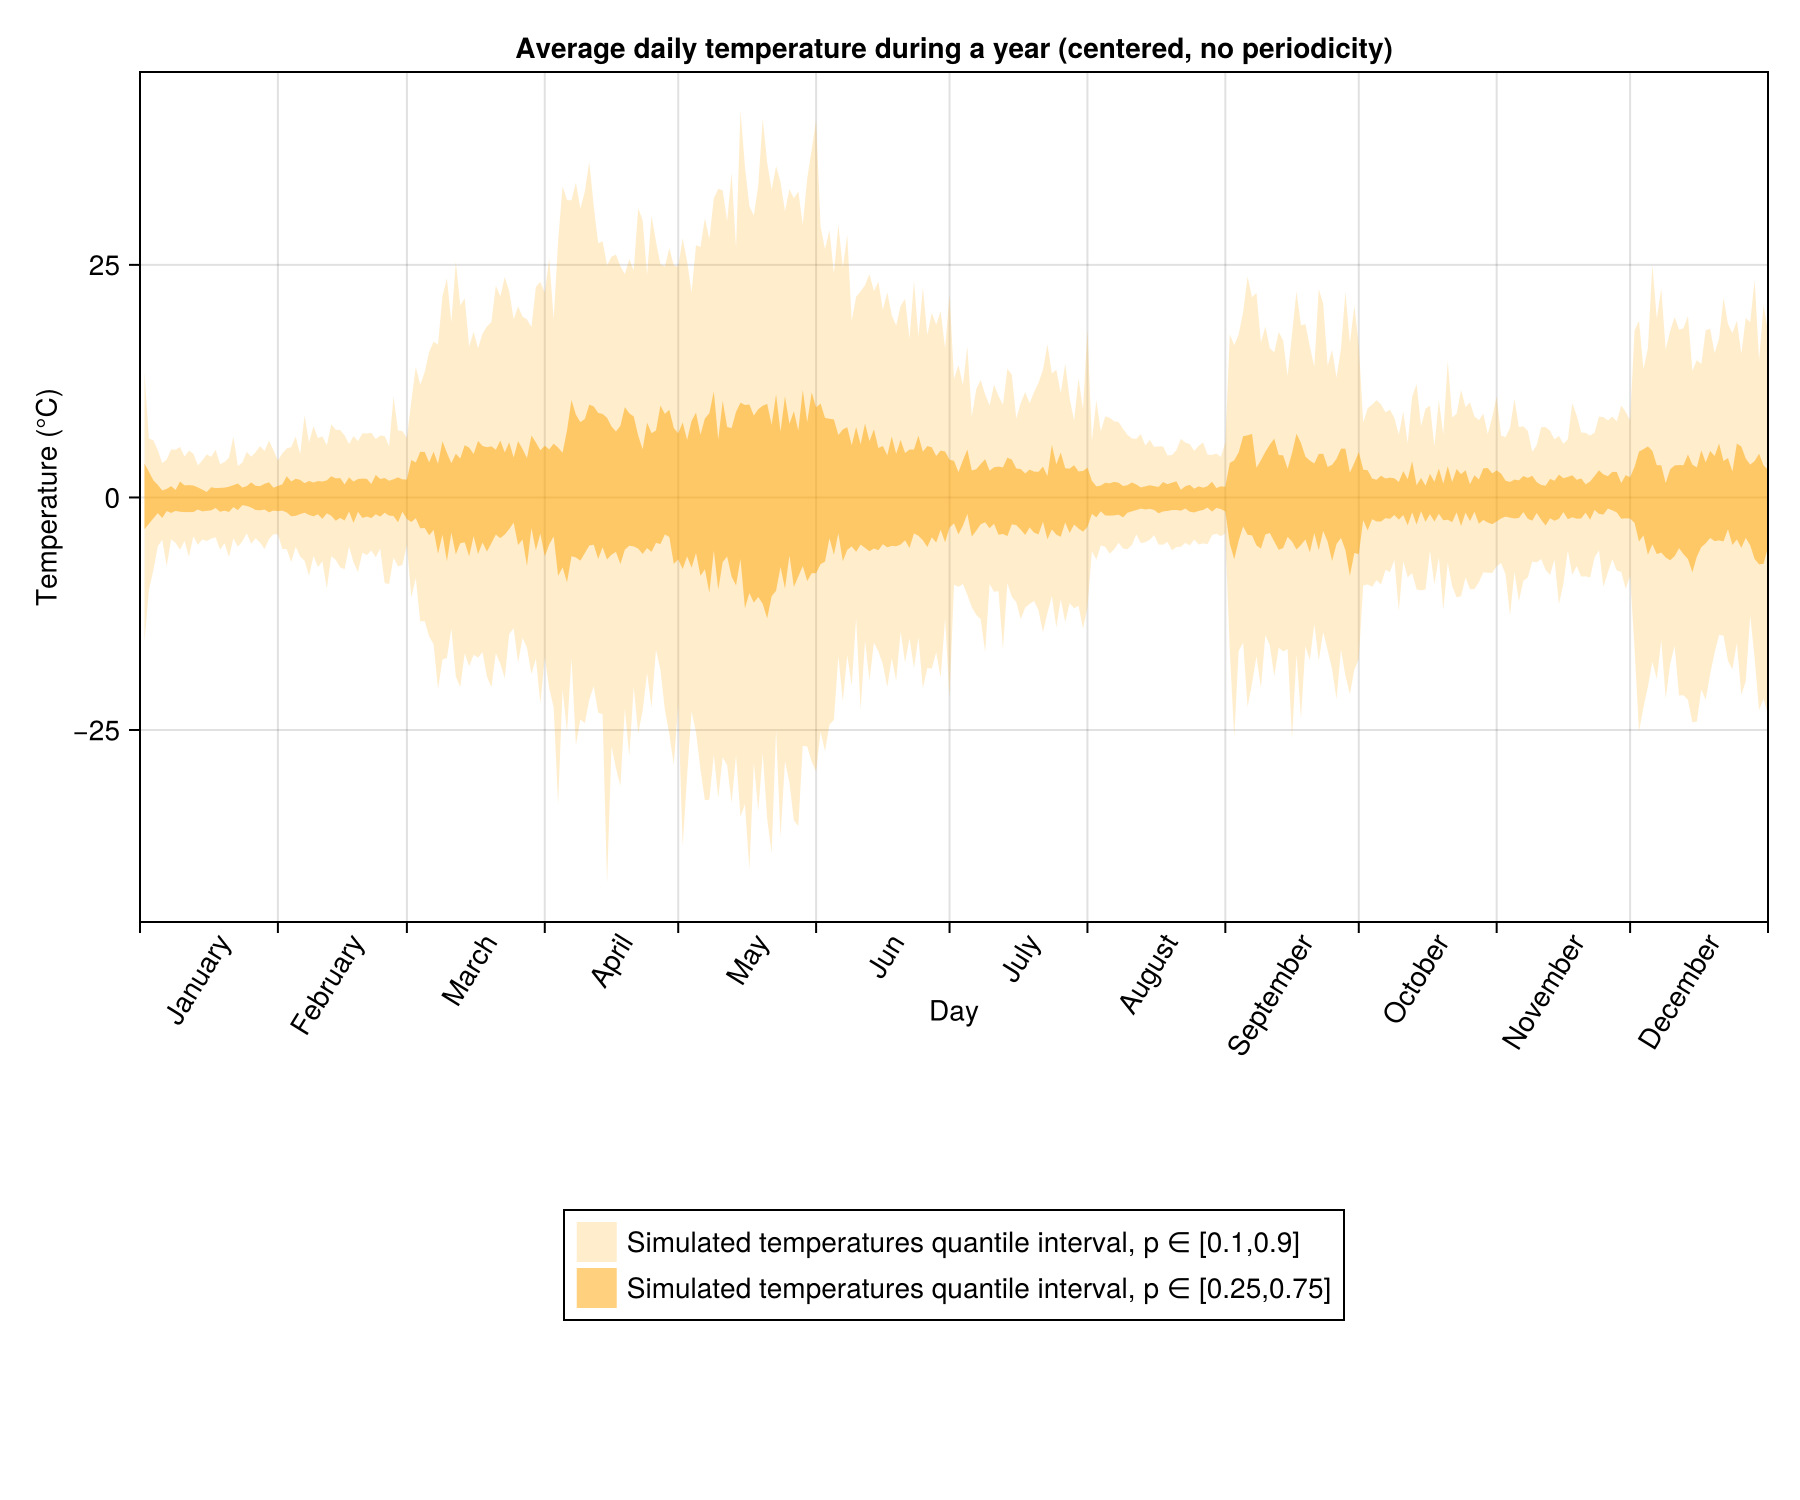

In [17]:
include("utils/Plotting.jl")
PlotYearCurves([],
["Simulated temperatures quantile interval, p ∈ [0.1,0.9]","Simulated temperatures quantile interval, p ∈ [0.25,0.75]"],
"Average daily temperature during a year (centered, no periodicity)",
[(minimum.(sample_),maximum.(sample_)),(quantile.(sample_,0.25),quantile.(sample_,0.75))],
[("orange",0.2),("orange",0.5)]
)